In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import datetime
import requests
import os
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
import time
from scipy.stats import skew, kurtosis
import ast
from polygon import RESTClient
from polygon.rest.models.request import RequestOptionBuilder
api_key = "HsOX1rl8t3B1AJfl4O2uqscUp372l7EF"
ticker = "SPY240802C00530000"
from scipy.stats import kurtosis, skew
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from requests.exceptions import HTTPError

In [2]:
date = "2024-06-11"
type ="C"
strike = 540

In [3]:
# Define US holidays for the year 2024
us_holidays = holidays.US(years=2024)

# Function to calculate the next working day
def next_working_day(date):
    next_day = date + timedelta(days=1)
    
    # Check if the next day is a weekend or holiday and adjust accordingly
    while next_day.weekday() in (5, 6) or next_day in us_holidays:
        next_day += timedelta(days=1)
    
    return next_day
next_work = datetime.strptime(date, '%Y-%m-%d')
next_working_date = next_working_day(next_work)

In [4]:
# Function to calculate the next working day
def next_working_day(date):
    next_day = date + timedelta(days=1)
    
    # Check if the next day is a weekend or holiday and adjust accordingly
    while next_day.weekday() in (5, 6) or next_day in us_holidays:
        next_day += timedelta(days=1)
    
    return next_day

# Calculate the next working day
next_work = datetime.strptime(date, '%Y-%m-%d')
next_working_date = next_working_day(next_work)
expiration_date = next_working_date.strftime("%y%m%d")

# Print the result
print(f"Trading Date: {date}")
print(f"Expiration Date: {next_working_date.strftime('%Y-%m-%d')}")


# Function to replace the strike value in the given string
def replace_strike(symbol, strike, expiration_date):
    # Format the strike value to be 8 digits long, padded with zeros
    formatted_strike = f"{strike * 1000:08d}"  # Multiply by 1000 to get the correct format
    # Construct the new symbol
    new_symbol = f"SPY{expiration_date}{type}{formatted_strike}"
    return new_symbol
expiration_date = next_working_date.strftime("%y%m%d")
# Replace the date and strike in the ticker
ticker = replace_strike(ticker, strike, expiration_date)
print(f"Ticker: {ticker}")

Trading Date: 2024-06-11
Expiration Date: 2024-06-12
Ticker: SPY240612C00540000


In [5]:
def get_option_price(ticker, date):
    # Convert the date to the correct format (YYYY-MM-DD)
    API_KEY = 'HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
    url = f"https://api.polygon.io/v1/open-close/O:{ticker}/{date}?adjusted=true&apiKey={API_KEY}"
    print(url)  # For debugging purposes
    response = requests.get(url)
    
    if response.status_code == 200:
        try:
            data = response.json()
            if 'close' in data:
                return data['close']
            else:
                raise ValueError("Response JSON does not contain 'close' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [6]:
open_trade_price = get_option_price(ticker, date) *100
close_trade_date = next_working_date.date() 
close_trade_price = get_option_price(ticker, close_trade_date) *100
beneficio = close_trade_price - open_trade_price
perc = beneficio*100/open_trade_price
beneficio = round(beneficio,0)
perc = round(perc,0) 

https://api.polygon.io/v1/open-close/O:SPY240612C00540000/2024-06-11?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
https://api.polygon.io/v1/open-close/O:SPY240612C00540000/2024-06-12?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF


In [7]:
def get_history_price(ticker, date, expiration_day):
    # Convert the date and expiration_day to the correct format (YYYY-MM-DD)
    API_KEY = 'HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
    url = f"https://api.polygon.io/v2/aggs/ticker/O:{ticker}/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    print(url)  # For debugging purposes
    response = requests.get(url)
    
    if response.status_code == 200:
        try:
            data = response.json()
            # Extract necessary data and create a DataFrame
            if 'results' in data:
                results = data['results']
                df = pd.DataFrame(results)
                df = df.rename(columns={'t': 'timestamp', 'o': 'open', 'c': 'close', 'l': 'low', 'h': 'high'})
                return df[['timestamp', 'open', 'close', 'low', 'high']]
            else:
                raise ValueError("Response JSON does not contain 'results' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [8]:
closing_day = next_working_date.date()
option_data = get_history_price(ticker, date, closing_day)

https://api.polygon.io/v2/aggs/ticker/O:SPY240612C00540000/range/1/minute/2024-06-11/2024-06-12?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF


In [9]:
def get_stock_price(date, expiration_day):
    API_KEY = 'HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
    url = f"https://api.polygon.io/v2/aggs/ticker/SPY/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    print(url)  # For debugging purposes
    response = requests.get(url)
    
    if response.status_code == 200:
        try:
            data = response.json()
            if 'results' in data:
                return [(result['t'], result['c']) for result in data['results']]
            else:
                raise ValueError("Response JSON does not contain 'results' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return []

In [10]:
stock_prices = get_stock_price(date, closing_day)
stock_prices = pd.DataFrame(stock_prices,columns=["timestamp", "stock_price"] )

https://api.polygon.io/v2/aggs/ticker/SPY/range/1/minute/2024-06-11/2024-06-12?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF


In [11]:
option_data['human_dates'] = option_data['timestamp'].apply(lambda ts: datetime.fromtimestamp(ts / 1000).strftime('%Y-%m-%d %H:%M:%S'))

In [12]:
df = pd.merge(option_data, stock_prices, on="timestamp", how="left")
df.tail(5)

,timestamp,open,close,low,high,human_dates,stock_price
723,1718222100000,1.87,2.30,1.66,2.30,2024-06-12 21:55:00,542.210
724,1718222160000,2.27,2.24,2.24,2.33,2024-06-12 21:56:00,542.240
725,1718222220000,2.25,2.12,2.10,2.30,2024-06-12 21:57:00,542.135
726,1718222280000,2.41,1.94,1.94,2.41,2024-06-12 21:58:00,541.890
727,1718222340000,1.87,1.30,1.23,1.87,2024-06-12 21:59:00,541.340


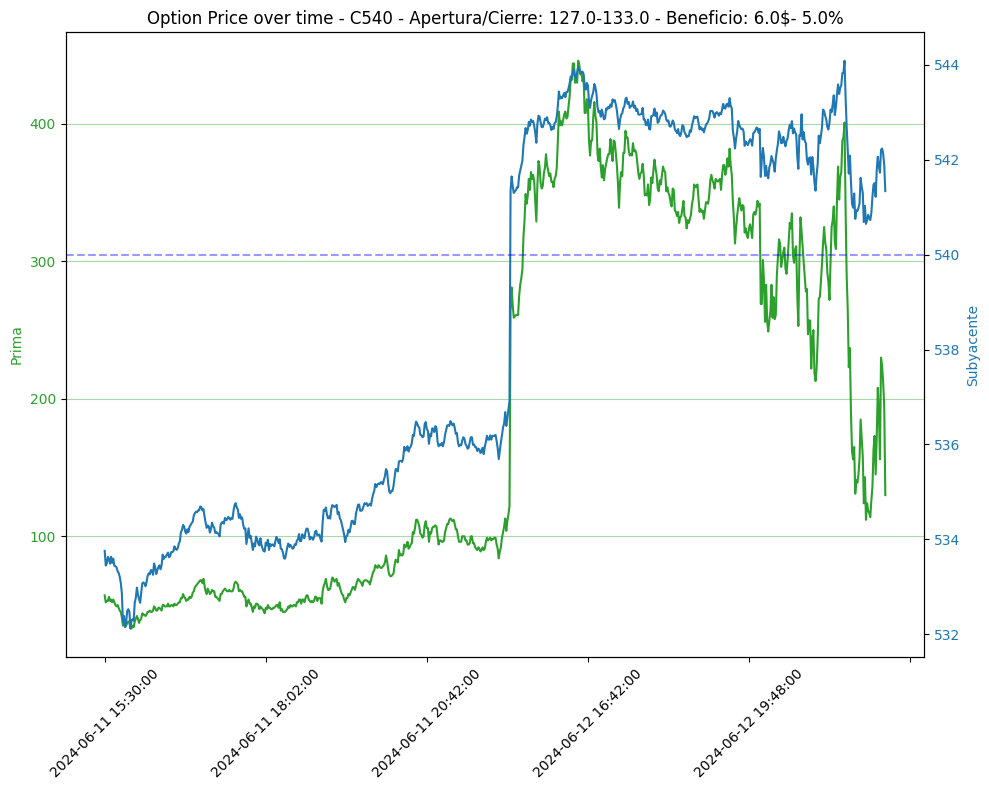

Precio de apertura: 127.0
Precio de cierre  : 133.0
Beneficio: 6.0$- 5.0%


In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(df['human_dates'], df['close']*100, color='tab:green')
ax1.set_title(f'Option Price over time - {type}{strike} - Apertura/Cierre: {open_trade_price}-{close_trade_price} - Beneficio: {beneficio}$- {perc}%')
ax1.set_ylabel('Prima', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')
plt.xticks(rotation=45)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax2 = ax1.twinx()
ax2.plot(df['human_dates'], df['stock_price'], color='tab:blue')
ax2.set_ylabel('Subyacente', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.axhline(y=strike, color='blue', linestyle='--',alpha=0.4)
fig.tight_layout()
ax1.yaxis.grid(True,color='tab:green',alpha=0.4)
output_dir = 'chart_output'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'option_value_plot_{timestamp}.png'
output_path = os.path.join(output_dir, filename)
plt.savefig(output_path)
plt.show()
print(f"Precio de apertura: {open_trade_price}")
print(f"Precio de cierre  : {close_trade_price}")
print(f"Beneficio: {beneficio}$- {perc}%")